In [15]:
!pip install -q kaggle

In [16]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [17]:
! cp kaggle.json ~/.kaggle/

In [18]:
! chmod 600 ~/.kaggle/kaggle.json

In [19]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:30<00:00, 49.4MB/s]
100% 2.29G/2.29G [00:31<00:00, 79.4MB/s]


In [20]:
! unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2
from keras import Sequential
from keras.layers import Flatten,Dense,BatchNormalization,Dropout,LeakyReLU,GlobalAveragePooling2D
from keras.optimizers import Adam,RMSprop
from keras.losses import BinaryCrossentropy
from keras.applications.resnet_v2 import ResNet50V2
from keras.callbacks import EarlyStopping

Loading Data & Data Processing

In [22]:
train_path = "/content/chest_xray/train/"
val_path = "/content/chest_xray/val/"
test_path = "/content/chest_xray/test/"

normal = glob.glob(train_path+"NORMAL/*.jpeg")
pneumonia = glob.glob(train_path+"PNEUMONIA/*.jpeg")

number_of_normal_img = len(normal)
number_of_pneumonia_img = len(pneumonia)
print("number of normal images:", number_of_normal_img)
print("number of pneumonia images:", number_of_pneumonia_img)

number of normal images: 1341
number of pneumonia images: 3875


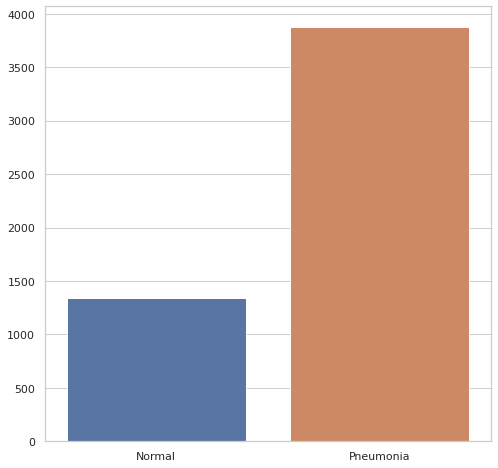

In [23]:
sns.set_theme(style="whitegrid")
plt.figure(figsize = (8,8))
ax = sns.barplot( x = ["Normal", "Pneumonia"], y = [number_of_normal_img, number_of_pneumonia_img])

Data Visualization

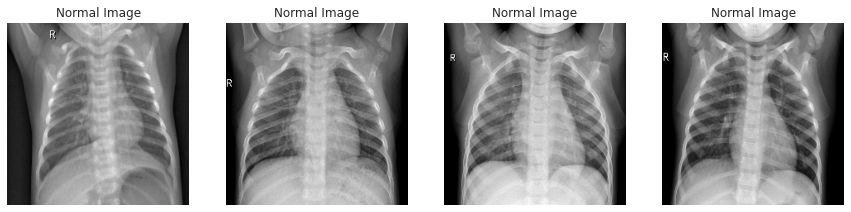

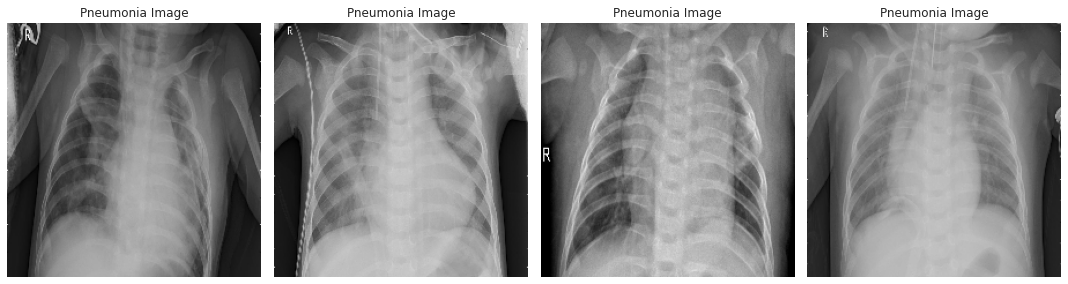

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal[i])
    img = cv2.resize(img, (220,220))
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Normal Image")
    
    
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(pneumonia[i])
    img = cv2.resize(img, (220,220))
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Pneumonia Image")
fig.tight_layout()    
plt.show()

Data Augmentation

In [25]:
train_val_generator = ImageDataGenerator(rescale=1./255,horizontal_flip=True,zoom_range=0.3)
test_generator = ImageDataGenerator(rescale=1./255)

train = train_val_generator.flow_from_directory(train_path,
                                               batch_size=128,
                                               target_size=(220,220),
                                               color_mode="rgb",
                                               class_mode="binary",
                                               shuffle=True,
                                               seed=42,
                                               subset="training")

Found 5216 images belonging to 2 classes.


In [28]:
val = train_val_generator.flow_from_directory(val_path,
                                               batch_size=4,
                                               target_size=(220,220),
                                               color_mode="rgb",
                                               class_mode="binary",
                                               shuffle=True,
                                               seed=42)

Found 16 images belonging to 2 classes.


In [30]:
test = test_generator.flow_from_directory(test_path,
                                          batch_size=32,
                                          target_size=(220,220),
                                          color_mode="rgb",
                                          class_mode="binary")

Found 624 images belonging to 2 classes.


Deep Residual Network (ResNet)

In [31]:
resnet50 = ResNet50V2(weights = "imagenet", input_shape = (220,220,3), include_top = False)

94683136/94668760 [==============================] - 1s 0us/step


In [32]:
for layer in resnet50.layers:
    layer.trainable = False

In [33]:
model = Sequential()

model.add(resnet50)

for layer in resnet50.layers:
    layer.trainable = False
    
model.add(Flatten())

model.add(Dense(units = 128, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(units = 1, activation = "sigmoid"))

Compiling the model

In [34]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               12845184  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 36,410,113
Trainable params: 12,845,313
Non-trainable params: 23,564,800
_________________________________________________________________


In [41]:
# tf.keras.utils.plot_model(model, to_file='model1.png', show_layer_names=True, show_shapes=True)

In [42]:
hist = model.fit(train,validation_data=val,epochs=10)

Epoch 1/10
41/41 [==============================] - 95s 2s/step - loss: 0.1418 - accuracy: 0.9479 - val_loss: 0.2683 - val_accuracy: 0.8125
Epoch 2/10
41/41 [==============================] - 94s 2s/step - loss: 0.1349 - accuracy: 0.9444 - val_loss: 0.6804 - val_accuracy: 0.7500
Epoch 3/10
41/41 [==============================] - 95s 2s/step - loss: 0.1308 - accuracy: 0.9486 - val_loss: 2.0228 - val_accuracy: 0.7500
Epoch 4/10
41/41 [==============================] - 94s 2s/step - loss: 0.1322 - accuracy: 0.9515 - val_loss: 0.7707 - val_accuracy: 0.8125
Epoch 5/10
41/41 [==============================] - 94s 2s/step - loss: 0.1096 - accuracy: 0.9586 - val_loss: 0.4094 - val_accuracy: 0.7500
Epoch 6/10
41/41 [==============================] - 96s 2s/step - loss: 0.1062 - accuracy: 0.9571 - val_loss: 0.3164 - val_accuracy: 0.8750
Epoch 7/10
41/41 [==============================] - 95s 2s/step - loss: 0.1159 - accuracy: 0.9574 - val_loss: 1.1636 - val_accuracy: 0.7500
Epoch 8/10
41/41 [==

Evaluate the Model

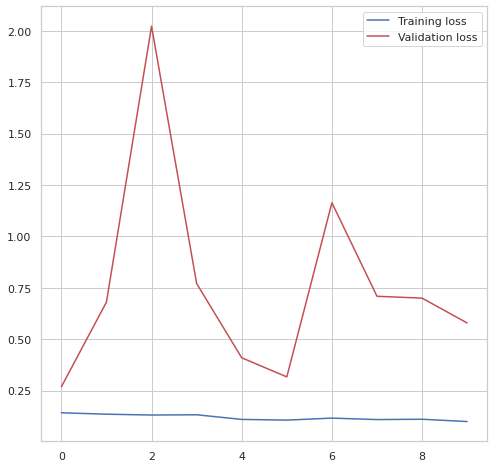

<Figure size 432x288 with 0 Axes>

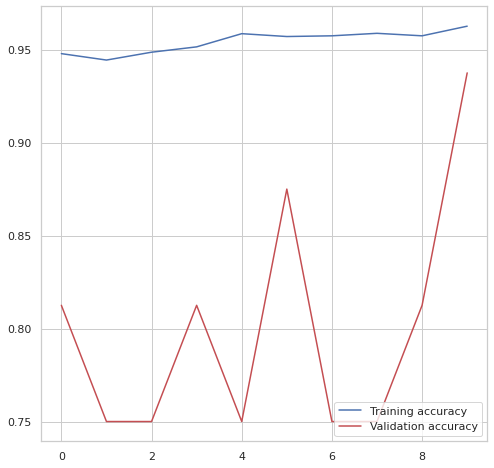

In [43]:
plt.figure(figsize=(8,8))
plt.plot(hist.history['loss'], color='b', label="Training loss")
plt.plot(hist.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(8,8))
plt.plot(hist.history['accuracy'], color='b', label="Training accuracy")
plt.plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend(loc = "lower right")
plt.show()

In [44]:
test_results = model.evaluate(test)

20/20 [==============================] - 6s 288ms/step - loss: 0.2092 - accuracy: 0.9279
